## Code for computing the structure function (given a light curve)
In this demonstration, we will use the following definition for SF:

$$\operatorname{SF}^{2}(\Delta t)=\frac{1}{P} \sum_{i, j>i}^{P}\left(m_{i}-m_{j}\right)^{2}-\sigma_{i}^{2}-\sigma_{j}^{2}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# eztao for simulation DRW
from eztao.carma import DRW_term
from eztao.ts import gpSimRand

### 1. Develop using Gaussian random noise

In [2]:
# generate gaussian random time series
size=1000
t = np.random.uniform(size=size)*3000
t = t[np.argsort(t)]
y = np.random.normal(scale=1, size=size)[np.argsort(t)]
yerr = np.random.normal(scale=0.05, size=size)[np.argsort(t)]

<ErrorbarContainer object of 3 artists>

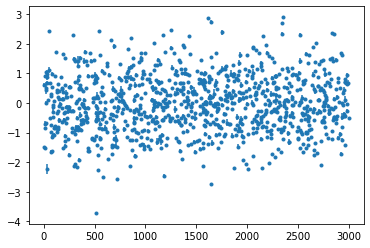

In [3]:
# viz the 'LC'
plt.errorbar(t, y, yerr, fmt='.')

In [4]:
## compute dt and dm for all gaps
# dt
dt_matrix = t.reshape((1, t.size)) - t.reshape((t.size, 1))
dts = dt_matrix[dt_matrix > 0].flatten().astype(np.float16)

# dm
dm_matrix = y.reshape((1, y.size)) - y.reshape((y.size, 1))
dms = dm_matrix[dt_matrix > 0].flatten().astype(np.float16)

# err^2
err2_matrix = yerr.reshape((1, yerr.size))**2 + yerr.reshape((yerr.size, 1))**2
err2s = err2_matrix[dt_matrix > 0].flatten().astype(np.float16)

In [5]:
## SF for each pair of observations, will give underflow error given limited precision
sfs = dms**2 - err2s

<ipython-input-5-dd4fa4572d6b>:2: RuntimeWarning: underflow encountered in square
  sfs = dms**2 - err2s


In [6]:
## bin sfs by dts using log_dt bins
max_dt = 3500 # arbitrary
log_bins = np.logspace(np.log10(dts.min())-0.1, np.log10(max_dt)+0.1, 50)

# the line below will throw error if the bins are not covering the whole range
SFs, bin_edgs, _ = binned_statistic(dts, sfs, 'mean', log_bins)

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Text(0.5, 1.0, 'SF for a gaussian white noise')

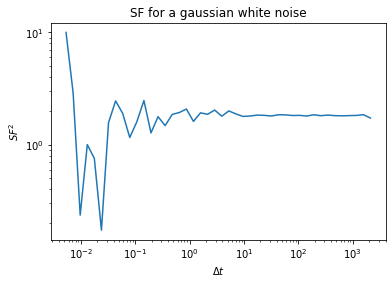

In [7]:
bin_cents = (bin_edgs[0:-1] + bin_edgs[1:])/2
plt.loglog(bin_cents, SFs)
plt.xlabel('$\Delta t$')
plt.ylabel('$SF^2$')
plt.title('SF for a gaussian white noise')

### 2. Test on simulated DRW

In [8]:
amp = 0.2
tau = 100
DRW_kernel = DRW_term(np.log(amp), np.log(tau))
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 1000)

<ErrorbarContainer object of 3 artists>

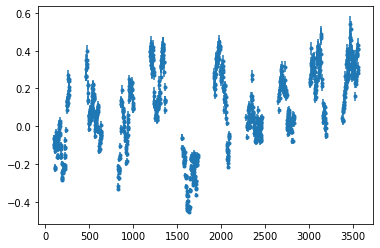

In [9]:
# vis drw lc
plt.errorbar(t, y, yerr, fmt='.')

In [10]:
def SF2(t, y, yerr, bins):
    ## compute dt and dm for all gaps
    # dt
    dt_matrix = t.reshape((1, t.size)) - t.reshape((t.size, 1))
    dts = dt_matrix[dt_matrix > 0].flatten().astype(np.float16)

    # dm
    dm_matrix = y.reshape((1, y.size)) - y.reshape((y.size, 1))
    dms = dm_matrix[dt_matrix > 0].flatten().astype(np.float16)

    # err^2
    err2_matrix = yerr.reshape((1, yerr.size))**2 + yerr.reshape((yerr.size, 1))**2
    err2s = err2_matrix[dt_matrix > 0].flatten().astype(np.float16)
    
    ## SF for each pair of observations
    sfs = dms**2 - err2s
    
    # SF for at specific dt
    # the line below will throw error if the bins are not covering the whole range
    SFs, bin_edgs, _ = binned_statistic(dts, sfs, 'mean', bins)

    return SFs, (bin_edgs[0:-1] + bin_edgs[1:])/2

In [11]:
min_dt = np.diff(t).min()
max_dt = t[-1] - t[0]
log_bins = np.logspace(np.log10(min_dt)-0.1, np.log10(max_dt)+0.1, 20)

#### Compute SF^2 and plot

<ipython-input-10-4e82f509bdc9>:16: RuntimeWarning: underflow encountered in square
  sfs = dms**2 - err2s
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


Text(0.5, 1.0, 'SF for a DRW')

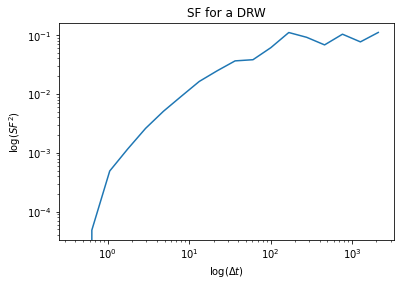

In [12]:
SF, b_cent = SF2(t, y, yerr, log_bins) 
plt.loglog(b_cent, SF)
plt.xlabel('log($\Delta t$)')
plt.ylabel('log($SF^2$)')
plt.title('SF for a DRW')